In [ ]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install plot


In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchsummary import summary as summary_
import numpy as np
from tqdm import tqdm_notebook
import random
import matplotlib.pyplot as plt
import copy

/Users/junsoor/PycharmProjects/DeepAssn2/venv/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Initial Settings for random seed, device
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.005
epochs = 20

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image, label, image_size):
        self.image_list = image
        self.label_list = label
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = self.transform(self.image_list[index])
        label = self.label_list[index]
        
        return image, label
    
    def transform(self, image):
        n_channel = image.shape[0]
        transformer = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor()
        ])
        converted_image = transformer(image)
        if n_channel == 3:
            converted_image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(converted_image)
        
        return converted_image

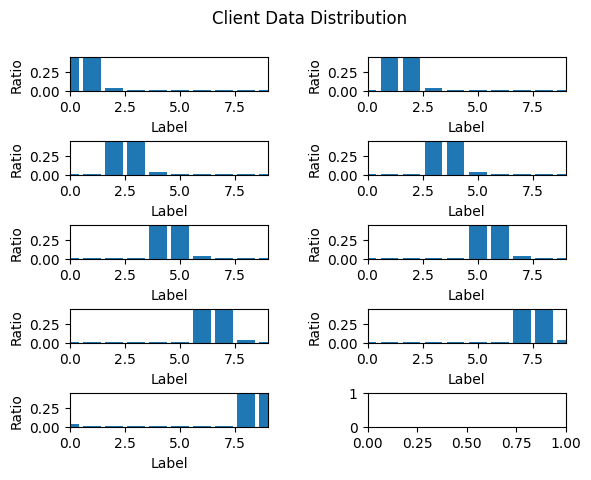

In [4]:
client_data_distributions = [
    # data_distribution_idx: 0
    [
      [0.45, 0.45, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.45, 0.45, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.45, 0.45, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.45, 0.45, 0.03, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.45, 0.45, 0.03, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.45, 0.45, 0.03, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.45, 0.45, 0.03, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.45, 0.45, 0.03],
      [0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.45, 0.45],
    ],
    # data_distribution_idx: 1
    [
      [0.9, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.9, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.9, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.9, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.9, 0.02, 0.01, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.9, 0.02, 0.01, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.9, 0.02, 0.01, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.9, 0.02, 0.01],
      [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.9, 0.02],
    ]
]

fig, axes = plt.subplots(nrows=5, ncols=2)
fig.suptitle("Client Data Distribution")

plt.subplots_adjust(wspace=0.5, hspace=1.5)

data_distribution_idx = 0 # 0 or 1
max_x = 9
max_y = max(client_data_distributions[data_distribution_idx][0])

def plot_client_datasets(client_datasets):
    plt.subplots_adjust(wspace=0.5, hspace=1.5)
    temp = 0
    for i in range(5):
        for j in range(2):
            if i == 4 and j == 1:
              continue
            axes[i][j].bar(range(len(client_datasets[i])), client_datasets[temp])
            
            axes[i][j].set_xlim(0, max_x)
            axes[i][j].set_ylim(0, max_y)

            axes[i][j].set_xlabel("Label")
            axes[i][j].set_ylabel("Ratio")
            temp+=1

    plt.show()

plot_client_datasets(client_data_distributions[data_distribution_idx])


In [5]:
new_image_size = (32, 32)
test_seq = [
   transforms.ToTensor(),
]
train_transform = transforms.Compose([
    transforms.RandomAffine(
        10, shear=10
    )] + test_seq)
# Load the original MNIST dataset
train_loaders = []
test_loaders = []
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
train_dataset = torch.utils.data.random_split(train_dataset, [1500, 58500])[0]
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose(test_seq))
test_len = len(test_dataset)
test_dataset = torch.utils.data.random_split(test_dataset, [200,test_len - 200])[0]

x_train, y_train = zip(*train_dataset)
x_test, y_test = zip(*test_dataset)
x_train = torch.cat(x_train, dim=0)[:, None, :, :]
y_train = torch.tensor(y_train)[:]
x_test = torch.cat(x_test, dim=0)[:, None, :, :]
y_test = torch.tensor(y_test)[:]

train_dataset = CustomDataset(x_train, y_train, image_size=[32, 32])
test_dataset  = CustomDataset(x_test, y_test, image_size=[32, 32])

# Make imbalanced data
num_classes = 10
class_labels = range(num_classes)

for client_idx in range(9):
    sample_probs = client_data_distributions[data_distribution_idx][client_idx].copy()
    idx_to_del = []
    idx_to_del_test = []
    idx_to_del = [i for i, (_, label) in enumerate(train_dataset) if random.random() > sample_probs[label]]
    idx_to_del_test = [i for i, (_, label) in enumerate(test_dataset) if random.random() > sample_probs[label]]

    imbalanced_train_dataset = train_dataset
    imbalanced_train_dataset = torch.utils.data.Subset(imbalanced_train_dataset, [i for i in range(len(train_dataset)) if i not in idx_to_del])
    imbalanced_train_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, batch_size=16, shuffle=True)
    train_loaders.append(imbalanced_train_loader)
    imbalanced_test_dataset = test_dataset
    imbalanced_test_dataset = torch.utils.data.Subset(imbalanced_test_dataset, [i for i in range(len(test_dataset)) if i not in idx_to_del_test])
    imbalanced_test_loader = torch.utils.data.DataLoader(imbalanced_test_dataset, batch_size=16, shuffle=True)
    test_loaders.append(imbalanced_test_loader)

for train_loader in train_loaders:
    label_dict = dict()
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(len(data)):
            if target[i].item() not in label_dict:
                label_dict[target[i].item()] = 1
            else:
                label_dict[target[i].item()] += 1
print("BELOW IS TEST SET")
for train_loader in test_loaders:
    label_dict = dict()
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(len(data)):
            if target[i].item() not in label_dict:
                label_dict[target[i].item()] = 1
            else:
                label_dict[target[i].item()] += 1
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
label_dict = dict()
for batch_idx, (data, target) in enumerate(val_loader):
        for i in range(len(data)):
            if target[i].item() not in label_dict:
                label_dict[target[i].item()] = 1
            else:
                label_dict[target[i].item()] += 1
print("BELOW IS Validate SET")

# train_loaders, test_loaders, val_loader

BELOW IS TEST SET
BELOW IS Validate SET


In [6]:
class CNN(nn.Module):
    def __init__(self, init_parameters):
        super(CNN, self).__init__()
        
        self.init_parameters = init_parameters
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 10),
        )
        self.set_parameters()        

    def set_parameters(self):
        if self.init_parameters == {}:
            return
        parameterized_layer = {
            0: ['weight'],
            3: ['weight'],
            7: ['weight', 'bias']
        }
        parameters = list(self.init_parameters.values())
        i=0
        for layer, param_types in parameterized_layer.items():
            for param in param_types:
                if param == 'weight':
                    self.layers[layer].weight.data = parameters[i].clone().detach()
                else:
                    self.layers[layer].bias.data = parameters[i].clone().detach()
                i+=1

    def forward(self, x):
        x = self.layers(x)
        return x


# Define CNN model with given parameter
def define_CNN(parameters):
    model = CNN(parameters).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, optimizer


# Calculate model's parameter with using parameters from each model and weight ratios
def calculate_new_weight(parameters, weight_ratios):
    assert len(parameters) == len(weight_ratios), "Length of parameters and weight ratios should be equal"
    assert sum(weight_ratios) == 1, "Sum of weight ratios should be 1"
    
    averaged_parameter = {}
    for layer in parameters[0]:
        averaged_parameter[layer] = 0
        for i in range(len(weight_ratios)):
            averaged_parameter[layer] += weight_ratios[i]*parameters[i][layer]

    return averaged_parameter

In [7]:
def compute_prediction(model, input):
    prediction = model(input)
    
    return prediction

def compute_loss(prediction, label):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(prediction, label)

    return loss, loss.item()

def compute_accuracy(prediction, label):
    b_Prediction = torch.argmax(prediction, 1)
    bCorrect = (b_Prediction == label)
    accuracy = bCorrect.float().mean() * 100

    return accuracy

def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label).to("cpu").numpy()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)  

# FEDWAGG class
1. Initialize all clients with global model
2. Proceed with model update in each client
3. Compare the parameters of the updated model of each client and combine the three most similar clients to form a cluster. Since there are a total of nine clients, three clusters are configured. When constructing a cluster model by combining client models, the model is constructed by averaging the model parameters of each client.
4. For each cluster model, two clients are randomly sampled for each cluster, and the performance of the model is tested in the sample client to obtain a loss value. The loss function is cross-entropy.
5. Using the loss value as a result of the performance test of each cluster model, the probability weight corresponding to each cluster model is made (1-loss), and when the cluster models are combined into a global model, the weighted sum is carried out.


In [8]:
class FEDWAGG():
    def __init__(self, num_clients, num_clusters, num_clients_per_cluster, num_sample_clients_per_cluster, init_global_parameter, learning_rate, num_epochs, batch_size):
        self.num_clients = num_clients                                            # num_clients = 9
        self.num_clusters = num_clusters                                          # num_clusters = 3
        self.num_clients_per_cluster = num_clients_per_cluster                    # num_clusters_per_cluster = 3
        self.num_sample_clients_per_cluster = num_sample_clients_per_cluster      # num_sample_clients_per_cluster = 2
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.global_model_parameters = init_global_parameter
        self.clients_models = [0 for i in range(9)]
        self.clients_weights = [0 for i in range(9)]
        self.clusters = [0 for i in range(3)]                                                        # 2d list : [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
        self.cluster_models = [0 for i in range(3)]                                                  # CNN instances
        self.cluster_weights = [0 for i in range(3)]                                                 
        self.cluster_model_accuracy = [0 for i in range(3)]  # ?
        self.global_loss = []
        self.global_accuracy = []

    def train(self, num_training_iterations):
        for i in range(num_training_iterations):
            global_model, _ = define_CNN(self.global_model_parameters)
            (fedwagg_loss_test, fedwagg_accuracy_test) = test(global_model, val_loader)
            self.global_loss.append(fedwagg_loss_test['mean'])
            self.global_accuracy.append(fedwagg_accuracy_test['mean'])

            # Step 1: Initialize all clients (9) with the global model
            for j in range(self.num_clients):
                model, _ = define_CNN(self.global_model_parameters)
                self.clients_models[j] = model


            # Step 2: Train each client individually
            idx = 0
            for client_model in self.clients_models:
                client_optimizer = torch.optim.SGD(client_model.parameters(), lr=self.learning_rate)
                client_criterion = nn.CrossEntropyLoss()

                # Create client data loader for the current client
                client_dataloader = train_loaders[idx]

                for epoch in range(self.num_epochs):
                    for images, labels in client_dataloader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)

                        client_optimizer.zero_grad()
                        output = client_model(images)
                        loss = client_criterion(output, labels)
                        loss.backward()
                        client_optimizer.step()
                
                self.clients_weights[idx] = client_model.state_dict()
                idx += 1

            # Step 3: Construct clusters based on client weights            
            self.construct_clusters()

            # Step 4: Create cluster models by averaging weights of clients in the same cluster            
            idx = 0
            for cluster in self.clusters:
                cluster_parameters = [self.clients_weights[client_idx] for client_idx in cluster]
                self.cluster_weights[idx] = calculate_new_weight(cluster_parameters, [1/3, 1/3, 1 - 2/3])
                
                model, _ = define_CNN(self.cluster_weights[idx])  # Create a new instance of your cluster model
                self.cluster_models[idx] = model  # Add the model to the cluster models list

                idx += 1

            # Step 5: Calculate cluster model loss values
            idx = 0
            for cluster_idx, cluster_model in enumerate(self.cluster_models):
                sample_clients = []
                accuracy_list = []
                temp_accuracy = 0.0
                for j in range(3):
                  sample_clients += random.sample(self.clusters[j], self.num_sample_clients_per_cluster)   # sampling 2 clients for each cluster 

                for client_id in sample_clients:
                    client_dataloader = test_loaders[client_id]

                    correct_predictions = 0
                    total_predictions = 0

                    for images, labels in client_dataloader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)

                        output = cluster_model(images)
                        _, predicted_labels = torch.max(output, 1)  # Get the predicted labels
                        correct_predictions += (predicted_labels == labels).sum().item()
                        total_predictions += labels.size(0)

                    # Calculate accuracy
                    accuracy = correct_predictions / total_predictions
                    accuracy_list.append(accuracy)

                # Calculate average accuracy
                temp_accuracy = sum(accuracy_list) / len(accuracy_list)

                # accuracy should be in the range of 0~1
                self.cluster_model_accuracy[idx] = temp_accuracy
                idx += 1

            # Step 6: Combine cluster models into a global model with weighted sum            
            # weight for combining cluster models
            combining_weights = [(accuracy)/sum(self.cluster_model_accuracy) for accuracy in self.cluster_model_accuracy]
            combining_weights[-1] = 1- sum(combining_weights[:-1])

            self.global_model_parameters = calculate_new_weight(self.cluster_weights, combining_weights)

            # Create the global model
            self.global_model, self.optimizer = define_CNN(self.global_model_parameters)

        # Initialize all clients (9) with the final version of global model            
        for j in range(self.num_clients):
            model, _ = define_CNN(self.global_model_parameters)
            self.clients_models[j] = model
        

    def construct_clusters(self):
        # Calculate similarity between clients based on their weights and form clusters
        client_similarities = []    # client_similarities : 2d-list, client_similarities[i][j] : similarity of client i and j 

        for i in range(self.num_clients):
            similarity_scores = []            
            for j in range(self.num_clients):
                if i == j:
                    similarity_scores.append(0.0)
                else:
                    similarity_scores.append(self.calculate_similarity(self.clients_weights[i], self.clients_weights[j]))
            client_similarities.append(similarity_scores)

        # Form clusters based on similarity scores
        self.clusters = []
        remaining_clients = set(range(self.num_clients))    # remaining_clients : (0, 1, 2, 3, 4, 5, 6, 7, 8)

        while len(remaining_clients) > 0:
            cluster = set()
            start_client = random.choice(list(remaining_clients))
            cluster.add(start_client)
            remaining_clients.remove(start_client)

            while len(cluster) < self.num_clients_per_cluster:    # 3 clients per cluster
                max_sim = float('-inf')
                max_client = None

                for client in remaining_clients:
                    sim_sum = sum(client_similarities[client][c] for c in cluster)  # calculate similarity for cluster elements
                    avg_sim = sim_sum / len(cluster)

                    if avg_sim > max_sim:
                        max_sim = avg_sim
                        max_client = client

                cluster.add(max_client)
                remaining_clients.remove(max_client)

            self.clusters.append(list(cluster))

    def calculate_similarity(self, weights1, weights2):
        # Get parameter values from state_dict dictionaries
        params1 = torch.cat([value.flatten() for value in weights1.values()])
        params2 = torch.cat([value.flatten() for value in weights2.values()])

        # Calculate similarity between two clients based on their weights
        similarity = torch.nn.functional.cosine_similarity(params1, params2, 0).item()
        return similarity


# Usage example:
"""fedwagg = FEDWAGG(num_clients=9, num_clusters=3, num_clients_per_cluster=3, num_sample_clients_per_cluster=2, init_global_model={}, learning_rate=0.1, num_epochs=2, batch_size=64)
fedwagg.train(2)
"""

'fedwagg = FEDWAGG(num_clients=9, num_clusters=3, num_clients_per_cluster=3, num_sample_clients_per_cluster=2, init_global_model={}, learning_rate=0.1, num_epochs=2, batch_size=64)\nfedwagg.train(2)\n'

In [9]:
class FEDAVG():
    def __init__(self, num_clients, init_global_parameter, learning_rate, num_epochs, batch_size):
        self.num_clients = num_clients                                            # num_clients = 9
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.global_model_parameters = init_global_parameter  # Change: initial setting
        self.clients_models = [0 for i in range(9)]
        self.clients_weights = [0 for i in range(9)]
        self.global_accuracy = []
        self.global_loss = []

    def train(self, num_training_iterations):
        for i in range(num_training_iterations):
            global_model, _ = define_CNN(self.global_model_parameters)
            (fedwagg_loss_test, fedwagg_accuracy_test) = test(global_model, val_loader)
            self.global_loss.append(fedwagg_loss_test['mean'])
            self.global_accuracy.append(fedwagg_accuracy_test['mean'])
            # Step 1: Initialize all clients (9) with the global model
            for j in range(self.num_clients):
                model, _ = define_CNN(self.global_model_parameters)
                self.clients_models[j] = model

            # Step 2: Train each client individually
            idx = 0
            for client_model in self.clients_models:
                client_optimizer = torch.optim.SGD(client_model.parameters(), lr=self.learning_rate)
                client_criterion = nn.CrossEntropyLoss()

                # Create client data loader for the current client
                client_dataloader = train_loaders[idx]

                for epoch in range(self.num_epochs):
                    for images, labels in client_dataloader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)

                        client_optimizer.zero_grad()
                        output = client_model(images)
                        loss = client_criterion(output, labels)
                        loss.backward()
                        client_optimizer.step()

                self.clients_weights[idx] = client_model.state_dict()
                idx += 1
            combining_weights = [1/self.num_clients for _ in range(self.num_clients)]
            combining_weights[-1] = 1- sum(combining_weights[:-1])

            self.global_model_parameters = calculate_new_weight(self.clients_weights, combining_weights)
            self.global_model, self.optimizer = define_CNN(self.global_model_parameters)


        # Initialize all clients (9) with the final version of global model
        for j in range(self.num_clients):
            model, _ = define_CNN(self.global_model_parameters)
            self.clients_models[j] = model

# Usage example:
"""fedavg = FEDAVG(num_clients=9, init_global_model={}, learning_rate=0.01, num_epochs=2, batch_size=64)
fedavg.train(2)
"""

'fedavg = FEDAVG(num_clients=9, init_global_model={}, learning_rate=0.01, num_epochs=2, batch_size=64)\nfedavg.train(2)\n'

In [10]:
import matplotlib.pyplot as plt

def plot_curve(train, test, y_label, title):
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(range(len(train)), train, '-')
    plt.plot(range(len(test)),  test, '-')
    
    plt.xlabel('Round')
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.legend(["FedAvg", "FedWAGG"])
    plt.show()    

	FEDWAGG test loss  : 0.4765362556164081,  test acc  : 86.53845977783203
	 FEDAVG test loss  : 0.4738240631727072,  test acc  : 84.61538696289062


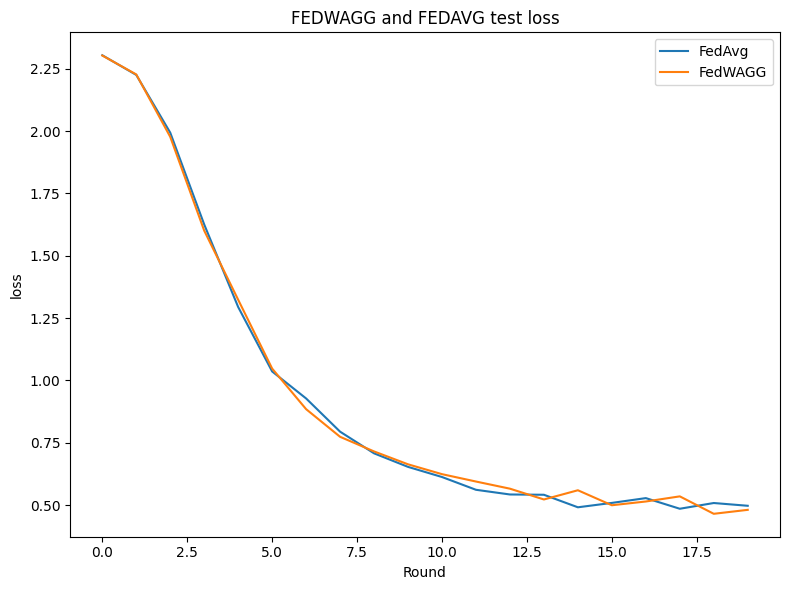

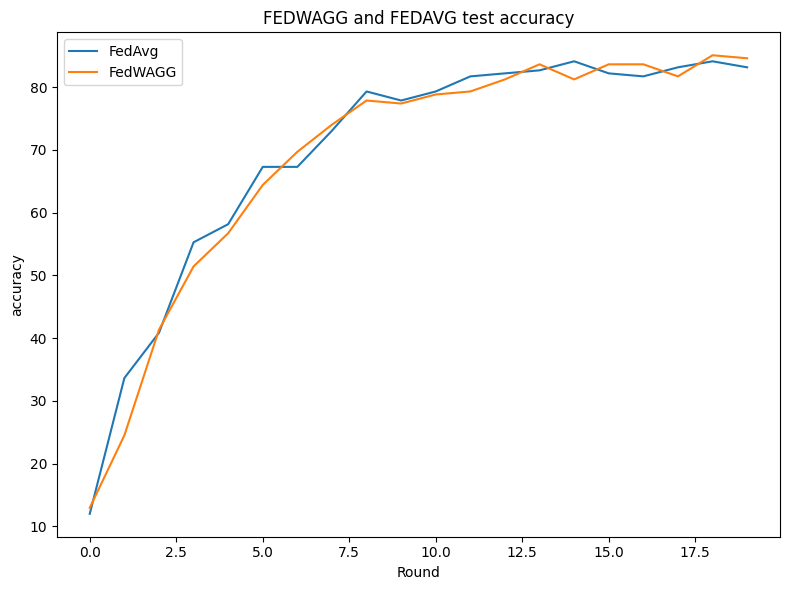

In [11]:
# Usage example:
initial_model, _ = define_CNN({})
inital_global_weight = initial_model.state_dict()

fedavg = FEDAVG(num_clients=9, init_global_parameter=inital_global_weight, learning_rate=0.01, num_epochs=5, batch_size=16)
fedwagg = FEDWAGG(num_clients=9, num_clusters=3, num_clients_per_cluster=3, num_sample_clients_per_cluster=2, init_global_parameter=inital_global_weight, learning_rate=0.01, num_epochs=5, batch_size=16)

fedavg.train(20)
fedwagg.train(20)

fedavg_global, _ = define_CNN(fedavg.global_model_parameters)
fedwagg_global, _ = define_CNN(fedwagg.global_model_parameters)

(fedwagg_loss_test, fedwagg_accuracy_test) = test(fedwagg_global, val_loader)

fedwagg_loss_mean_test      = fedwagg_loss_test['mean']
fedwagg_loss_std_test       = fedwagg_loss_test['std']

fedwagg_accuracy_mean_test  = fedwagg_accuracy_test['mean']
fedwagg_accuracy_std_test   = fedwagg_accuracy_test['std']

print(f"\tFEDWAGG test loss  : {fedwagg_loss_test['mean']},  test acc  : {fedwagg_accuracy_test['mean']}")

(fedavg_loss_test, fedavg_accuracy_test) = test(fedavg_global, val_loader)

fedavg_loss_mean_test      = fedavg_loss_test['mean']
fedavg_loss_std_test       = fedavg_loss_test['std']

fedavg_accuracy_mean_test  = fedavg_accuracy_test['mean']
fedavg_accuracy_std_test   = fedavg_accuracy_test['std']

print(f"\t FEDAVG test loss  : {fedavg_loss_test['mean']},  test acc  : {fedavg_accuracy_test['mean']}")

plot_curve(fedavg.global_loss, fedwagg.global_loss, 'loss', 'FEDWAGG and FEDAVG test loss')
plot_curve(fedavg.global_accuracy, fedwagg.global_accuracy, 'accuracy', 'FEDWAGG and FEDAVG test accuracy')

In [16]:
torch.save(fedavg_global, './fedavg.pt')
torch.save(fedwagg_global, './fedwagg.pt')
torch.save(test_dataset, './my_dataset.pt')